In [ ]:


import pandas as pd
import regex as re
import os

In [ ]:
df=pd.read_excel('/content/BeyondBlue_220123.xlsx')
#df=pd.read_csv('/content/export_QuickSearch_n3giAlMH.csv')
#df=df.loc[df.lang=="it"]

In [ ]:
len(df)

14739

In [ ]:
df.head()

,Unnamed: 0,0,Category
0,1,Safety planning involves creating a...,Suicide
1,2,Life gets pretty hard sometimes and...,Suicide
2,3,I feel like I have heaps of people ...,Suicide
3,4,i'm having such a hard time lately....,Suicide
4,5,I just need to write down how I’m f...,Suicide


Preprocessing

In [ ]:
for i in list(df.columns):
  i=str(i)
  if 'Unnamed' in i:
    df.drop(columns=i, inplace=True)


In [ ]:
#df['text']=df['title'].astype(str) + df['content'].astype(str)

In [ ]:
df.rename(columns={0:'text'}, inplace=True)

In [ ]:
df['text']=df['text'].astype(str)

In [ ]:
# Trasformazione in lower-case
df['text_processed'] = df['text'].map(lambda x: x.lower())

# Rimozione indirizzi email
df['text_processed'] = df['text_processed'].apply(lambda x: re.sub('\w+@\w+\.\w+?', '', x))

# Rimozione numeri
df['text_processed'] = df['text_processed'].apply(lambda x: re.sub('\d','', x))

# Rimozione della punteggiatura
df['text_processed']  = df['text_processed'].apply(lambda x: re.sub(r'[^\w\s]','', x))

# Rimozione parole composte
df['text_processed']  = df['text_processed'].astype(str).map(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

# Rimozione spazi
df['text_processed'] = df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

#rimozione spazi di inizio riga
df['text_processed'] = df['text_processed'].map(lambda x: x.lstrip()) 

#rimozione spazi di fine riga
df['text_processed'] = df['text_processed'].map(lambda x: x.rstrip()) 

list_special=['#','@','&', '','ü','í','ï','Ä','ú','Ä','ô', 'nan', '–', '¥', 'æ','º','∞','¬','Æ', 'ù','§','Ô','∏', '•','∫', '√','≈', '°', 'ò','≠' ]
for i in list_special:
  df['text_processed'] = df['text_processed'].str.replace( i ,'')

df['text_processed'] = df['text_processed'].str.replace('[^\dA-Za-z]', ' ')

df['text_processed'] = df['text_processed'].str.replace('Updated', '')
df['text_processed'] = df['text_processed'].str.replace('UPDATED', '')

df['text_processed'] = df['text_processed'].str.replace('CDT', '')
df['text_processed'] = df['text_processed'].str.replace('EST', '')
df['text_processed'] = df['text_processed'].str.replace('EDT', '')

df['text_processed'] = df['text_processed'].str.replace('cdt', '')
df['text_processed'] = df['text_processed'].str.replace('est', '')
df['text_processed'] = df['text_processed'].str.replace('est', '')



<ipython-input-9-ee58f0ff55b4>:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text_processed'] = df['text_processed'].str.replace('[^\dA-Za-z]', ' ')


In [ ]:
# df.sentiment=df.sentiment.astype(str)
# df.sentiment=df.sentiment.str.replace("-5", "Negative")

# df.sentiment=df.sentiment.str.replace("5", "Positive")
# df.sentiment=df.sentiment.str.replace("0", "Neutral")

In [ ]:
# df['target']=df['sentiment'].copy()

In [ ]:
#PREPROCESSING - LDA requires some basic pre-processing of text data
def tokenize_lemma_stopwords(text):
  tokens = nltk.tokenize.word_tokenize(text.lower())
# split string into words (tokens)
  tokens = [t for t in tokens if t.isalpha()]
# keep strings with only alphabets
  tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]
# put words into base form
  tokens = [stemmer.stem(t) for t in tokens]
  tokens = [t for t in tokens if len(t) > 2]
# remove short words, they're probably not useful
  tokens = [t for t in tokens if t not in stopwords]
# remove stopwords
  return tokens

In [ ]:

import nltk
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:

tok_ = nltk.tokenize.WhitespaceTokenizer()
lemm_ = nltk.stem.WordNetLemmatizer()

def lemmatize_text_verb(text):
    return [lemm_.lemmatize(w,'v') for w in tok_.tokenize(text)]
def lemmatize_text_adj(text):
    return [lemm_.lemmatize(w, 'a') for w in text]
def lemmatize_text(text):
    return [lemm_.lemmatize(w) for w in text]

df['text_processed'] = df['text_processed'].apply(lemmatize_text_verb).apply(lemmatize_text_adj).apply(lemmatize_text)

In [ ]:

df['text_processed']

0        [safety, plan, involve, create, structure, pla...
1        [life, get, pretty, hard, sometimes, and, many...
2        [feel, like, have, heap, people, around, for, ...
3        [have, such, hard, time, lately, have, some, p...
4        [just, need, write, down, how, feel, exhaust, ...
                               ...                        
14734    [last, year, husband, be, diagnose, with, ptsd...
14735    [be, recently, involve, traumatic, situation, ...
14736    [the, outside, everyone, think, be, the, perfe...
14737    [new, this, and, really, dont, know, what, do,...
14738    [just, want, say, hello, strugging, with, life...
Name: text_processed, Length: 14739, dtype: object

Prepare data for LDA Analysis


In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'updated' ,'updated edt','updated cst','updated cdt'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = df.text_processed.values.tolist()
data_words = list(sent_to_words(data))

In [ ]:

# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])


['safety', 'plan', 'involve', 'create', 'structure', 'plan', 'ideally', 'support', 'health', 'professional', 'someone', 'trust', 'work', 'youre', 'experience', 'suicidal', 'thought', 'feel', 'distress', 'crisis', 'safety', 'plan', 'start', 'thing', 'think', 'reason', 'live', 'distract', 'enjoyable', 'activity']


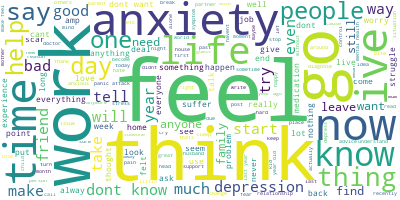

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
#long_string = ','.join(list(df['text_processed'].values))
long_string = ','.join(str(v) for v in list(df['text_processed'].values))
long_string=long_string.replace("'","")
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Measures 

In [ ]:
df.text_processed=df.text_processed.astype(str)

In [ ]:



from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# create a dictionary from the processed text
dictionary = Dictionary(df.text_processed.str.split())
id2word=dictionary

# convert the processed text into a list of lists of word indices
corpus = [dictionary.doc2bow(text) for text in df.text_processed.str.split()]


for i in range(2,5):
  # train your LDA model using the corpus
  lda = LdaModel(corpus, id2word=dictionary, num_topics=i, iterations=30, passes=5)

# calculate perplexity
  perplexity = lda.log_perplexity(corpus)

# calculate coherence
  cm = CoherenceModel(model=lda, texts=df.text_processed.str.split(), dictionary=dictionary, coherence='c_v')
  coherence = cm.get_coherence()
  print(i)
  print("Perplexity:", 2.71828**perplexity)
  print("Coherence:", coherence)
  print(" ")



2
Perplexity: 0.0014294849092411595
Coherence: 0.26733668109321196
 
3
Perplexity: 0.0014570991336323126
Coherence: 0.2733067978633167
 
4
Perplexity: 0.0014413730787002615
Coherence: 0.26839138954548325
 


In [ ]:
import numpy as np
print(np.log(0.001))
print(np.log(0.5))
print(np.log(0.999))

LDA model training


In [ ]:
from pprint import pprint
# number of topics
num_topics = 3
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

Analyzing LDA model results


In [ ]:
! pip install pyLDAvis

In [ ]:
import pickle 
import pyLDAvis
import pickle 
import pyLDAvis

In [ ]:
from pyLDAvis import *

In [ ]:
import gensim

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
! pip install pyLDAvis
import pyLDAvis
! pip install -U gensim


import gensim 
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn


In [ ]:
import pyLDAvis.gensim_models as gensimvis


In [ ]:
import os

In [ ]:

# Visualize the topics
pyLDAvis.enable_notebook()

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(num_topics))

In [ ]:
LDAvis_data_filepath


In [ ]:
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

In [ ]:
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

In [ ]:
print(np.log(-7))

Outputting the dominant topic for each text¶


In [ ]:
df.columns

In [ ]:

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)



In [ ]:
df_topic_sents_keywords

Rappresenta le prime parole per ogni cluster

In [ ]:
#df=pd.read_excel('/content/ferrero_LDA.xlsx')
#df=df.loc[~(df.lang=="it")]

In [ ]:
len(df)

In [ ]:
df_topic_sents_keywords.reset_index(drop=True, inplace=True)

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df_dominant_topic2 = pd.concat([df_topic_sents_keywords, df], axis=1)


In [ ]:
df_dominant_topic2.to_excel('LDA_260123.xlsx')
from google.colab import files
files.download('LDA_260123.xlsx') 

In [ ]:
import pandas as pd

data = [
    ("2 topics", 0.00144013, 0.265599891),
    ("3 topics", 0.001446888, 0.265076511),
    ("4 topics", 0.001452994, 0.274322653),
    ("5 topics", 0.001458299, 0.278441458),
    ("6 topics", 0.00145521, 0.271681194),
    ("7 topics", 0.001436363, 0.266922438)
]

df = pd.DataFrame(data, columns=["Number of topics", "Perplexity", "Coherence"])


In [ ]:
import matplotlib.pyplot as plt

ax = df.plot(x='Number of topics', y='Perplexity', kind='bar', legend=False)
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")

for i in range(len(df)):
    ax.text(i, df.Perplexity[i], round(df.Perplexity[i],4), ha='center', va='bottom')

plt.show()


In [ ]:
import matplotlib.pyplot as plt

ax = df.plot(x='Number of topics', y='Coherence', kind='bar', legend=False)
plt.xlabel("Number of topics")
plt.ylabel("Coherence")

for i in range(len(df)):
    ax.text(i, df.Coherence[i], round(df.Coherence[i],4), ha='center', va='bottom')

plt.show()
